In [29]:
import pandas as pd
import numpy as np
from math import sqrt

In [30]:
# Order by time
df = pd.read_csv('training.csv')
df['hour'] = df['timestamp'].apply(lambda x: int(x.split(':')[0]))
df['minute'] = df['timestamp'].apply(lambda x: int(x.split(':')[1]))
df['sin_hour'] = np.sin(df.hour*(2.*np.pi/24))
df['cos_hour'] = np.cos(df.hour*(2.*np.pi/24))
df = df.sort_values(by=['day','hour','minute'])
df.reset_index(0,drop=True,inplace=True)
df.drop('timestamp',axis=1,inplace=True)
df.head()

,geohash6,day,demand,hour,minute,sin_hour,cos_hour
0,qp09sx,1,0.021212,0,0,0.0,1.0
1,qp0dhg,1,0.013217,0,0,0.0,1.0
2,qp03x5,1,0.157956,0,0,0.0,1.0
3,qp09bw,1,0.001262,0,0,0.0,1.0
4,qp03wn,1,0.032721,0,0,0.0,1.0


In [31]:
# map static values
static = pd.read_hdf('staticValues.h5')
LongDict = dict(zip(static.geohash6,static.long))
LatDict = dict(zip(static.geohash6,static.lat))
ZoneDict = dict(zip(static.geohash6,static.zone))
distTo5Dict = dict(zip(static.geohash6,static.dist_to_high_demand5))
distTo7Dict = dict(zip(static.geohash6,static.dist_to_7))
totalDistDict = dict(zip(static.geohash6,static.totalDist))
xDict = dict(zip(static.geohash6,static.x))
yDict = dict(zip(static.geohash6,static.y))
zDict = dict(zip(static.geohash6,static.z))
df['long'] = df['geohash6'].map(LongDict)
df['lat'] = df['geohash6'].map(LatDict)
df['zone'] = df['geohash6'].map(ZoneDict)
df['dist_to_high_demand5'] = df['geohash6'].map(distTo5Dict)
df['dist_to_7'] = df['geohash6'].map(distTo7Dict)
df['totalDist'] = df['geohash6'].map(totalDistDict)
df['x'] = df['geohash6'].map(xDict)
df['y'] = df['geohash6'].map(yDict)
df['z'] = df['geohash6'].map(zDict)

In [32]:
# Generate lagged values
df['demand_s'] = df.groupby('geohash6')['demand'].shift(1)
df['demand_s_2'] = df.groupby('geohash6')['demand'].shift(2)
df['demand_s_3'] = df.groupby('geohash6')['demand'].shift(3)
df['demand_s_4'] = df.groupby('geohash6')['demand'].shift(4)
df['demand_s_5'] = df.groupby('geohash6')['demand'].shift(5)
df['demand_s_6'] = df.groupby('geohash6')['demand'].shift(6)
df['demand_s_7'] = df.groupby('geohash6')['demand'].shift(7)

In [33]:
# Generate ratios and moving averages
df['sum'] = df.groupby(['geohash6'])['demand_s'].cumsum()
df['count'] = df.groupby(['geohash6'])['demand_s'].cumcount()
df['mean'] = df['sum'] / df['count']
df['min'] = df.groupby(['geohash6'])['demand_s'].cummin()
df['max'] = df.groupby(['geohash6'])['demand_s'].cummax()
df.drop(['sum','count'],axis=1,inplace=True)
df['ma7'] = df.groupby(['geohash6'])['demand_s'].rolling(7).mean().reset_index(0,drop=True)
df['ma14'] = df.groupby(['geohash6'])['demand_s'].rolling(14).mean().reset_index(0,drop=True)
df['ma21'] = df.groupby(['geohash6'])['demand_s'].rolling(21).mean().reset_index(0,drop=True)
df['ma50'] = df.groupby(['geohash6'])['demand_s'].rolling(50).mean().reset_index(0,drop=True)
df['ma100'] = df.groupby(['geohash6'])['demand_s'].rolling(100).mean().reset_index(0,drop=True)
df['std'] = df.groupby(['geohash6'])['demand_s'].expanding().std().reset_index(0,drop=True)

In [35]:
# Generate zone and geohash moving averages
df['zoneEma14'] = df.groupby(['zone'])['demand_s'].apply(lambda x: x.ewm(span=14).mean())
df['zoneAverage'] = df.groupby(['zone'])['demand_s'].expanding().mean().reset_index(0,drop=True)
df['geoEma7'] = df.groupby(['geohash6'])['demand_s'].apply(lambda x: x.ewm(span=7).mean())
df['geoEma14'] = df.groupby(['geohash6'])['demand_s'].apply(lambda x: x.ewm(span=14).mean())
df['ma100_med'] = df.groupby(['geohash6'])['demand_s'].rolling(100).median().reset_index(0,drop=True)
df['geoEma7_var'] = df.groupby(['geohash6'])['demand_s'].apply(lambda x: x.ewm(span=7).var())

In [36]:
# Generate last week's demand at same time
df2 = df.copy(deep=True)
df2['last_week_day'] = df2.day + 7
df2 = df2[['geohash6','last_week_day','hour','minute','demand']]
new_df = pd.merge(df, df2,  how='left', left_on=['geohash6','day','hour','minute'], right_on = ['geohash6','last_week_day','hour','minute'])
df['demand_last_week'] = new_df['demand_y']

In [37]:
# Generate percentage of high demand 
df['count'] = df.groupby(['geohash6'])['demand_s'].cumcount()
df['high_demand'] = df['demand_s'].apply(lambda x: 1 if x>0.5 else 0)
df['high_demand_count'] = df.groupby(['geohash6'])['high_demand'].cumsum()
df['high_demand_perc'] = df['high_demand_count'] / df['count']

In [38]:
# Generate day of week
df['dayOfWeek'] = df['day'].apply(lambda x: x if x < 8 else x %7)
df['dayOfWeek'] = df['dayOfWeek'].apply(lambda x: 7 if x == 0 else x)
df.groupby('dayOfWeek')['dayOfWeek'].count()

dayOfWeek
1    620418
2    629281
3    633567
4    632786
5    610482
6    524054
7    555733
Name: dayOfWeek, dtype: int64

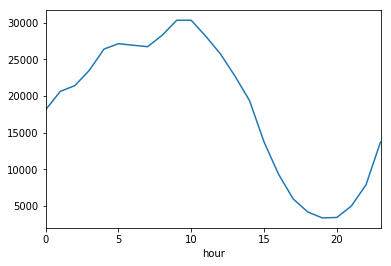

In [39]:
df.groupby(['hour'])['demand'].sum().plot()

In [40]:
# Indicate peak hours
df['peak'] = df['hour'].apply(lambda x: 1 if x < 15 else 0)

In [41]:
# Generate moving averages of broader geohash zones
df['geohash4'] = df.geohash6.str[3]
df['geohash5'] = df.geohash6.str[4]
df['geo4ZoneEma7'] = df.groupby(['geohash4'])['demand_s'].apply(lambda x: x.ewm(span=7).mean())
df['geo5ZoneEma7'] = df.groupby(['geohash5'])['demand_s'].apply(lambda x: x.ewm(span=7).mean())
df['geoEma7_2'] = df.groupby(['geohash4'])['demand_s_2'].apply(lambda x: x.ewm(span=7).mean())

In [42]:
df.drop(['geohash5','geohash4','count','high_demand','high_demand_count'],axis=1,inplace=True)
df.shape

(4206321, 45)

In [43]:
col2 = ['geohash6', 'day', 'long', 'lat', 'min', 'max', 'zone',
       'dist_to_high_demand5', 'dist_to_7', 'hour', 'minute', 'demand_s',
       'mean', 'ma7', 'ma14', 'ma21', 'ma50', 'ma100', 'std', 'zoneAverage',
       'geoEma7', 'geoEma14', 'zoneEma14', 'dayOfWeek', 'peak', 'totalDist',
       'sin_hour', 'cos_hour', 'demand_s_2', 'demand_s_3', 'demand_s_4',
       'demand_s_5', 'demand_s_6', 'demand_s_7', 'geoEma7_2', 'x', 'y', 'z',
       'geo4ZoneEma7', 'geo5ZoneEma7', 'high_demand_perc', 'geoEma7_var',
       'ma100_med', 'demand_last_week', 'demand']
df = df[col2]

In [44]:
df.columns

Index(['geohash6', 'day', 'long', 'lat', 'min', 'max', 'zone',
       'dist_to_high_demand5', 'dist_to_7', 'hour', 'minute', 'demand_s',
       'mean', 'ma7', 'ma14', 'ma21', 'ma50', 'ma100', 'std', 'zoneAverage',
       'geoEma7', 'geoEma14', 'zoneEma14', 'dayOfWeek', 'peak', 'totalDist',
       'sin_hour', 'cos_hour', 'demand_s_2', 'demand_s_3', 'demand_s_4',
       'demand_s_5', 'demand_s_6', 'demand_s_7', 'geoEma7_2', 'x', 'y', 'z',
       'geo4ZoneEma7', 'geo5ZoneEma7', 'high_demand_perc', 'geoEma7_var',
       'ma100_med', 'demand_last_week', 'demand'],
      dtype='object')

In [ ]:
df.to_hdf('predict.h5',key='df',mode='w')